In [44]:
# import all necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import yaml

# perform all the necessary steps to produce a standard run and save it to .tsv

In [45]:
with open("expsettings_2R.yml", "r") as stream:
    try:
        settings = yaml.safe_load(stream)
        print(settings)
    except yaml.YAMLError as exc:
        print(exc)

{'preferences': {'general': {'audioLib': 'SoundDevice', 'units': 'deg'}}, 'window': {'size': [1920, 1080], 'pos': [0, 0], 'color': [0, 0, 0], 'fullscr': False, 'winType': 'pyglet', 'waitBlanking': True, 'viewScale': [0.5, 0.5]}, 'monitor': {'name': 'default', 'width': 69.8, 'distance': 210, 'gamma': 1}, 'operating system': 'mac', 'mouse': {'visible': True}, 'eyetracker': {'model': 'eyelink'}, 'mri': {'TR': 1.5, 'topup_scan': False, 'topup_duration': 45, 'simulate': False, 'TA': 1.5, 'volumes': 100, 'sync': 't', 'skip': 0, 'sound': False}, 'PRF stimulus settings': {'Scanner sync': True, 'Screenshot': True, 'Squares in bar': 2, 'Bar pass steps': 20, 'Blanks length': 10, 'Bar orientations': [-1, 0, 90, -1, 180, 270, -1, 0, 90, -1, 180, 270, -1, 0, 90, -1, 180, 270, -1], 'Bar width in degrees': 1, 'Checkers motion speed': 3, 'Size fixation dot in degrees': 0.05, 'Bar step length': 5}, 'Task settings': {'response interval': 0.8, 'color switch interval': 3.5}}


In [46]:
# define standard bar orientations, create an empty list for the trials

# PRF stimulus settings:    
# bar_pass_steps = 20                # number of steps the bar takes to traverse the aperture
# blanks_length = 10                  # length of interbar periods (-1 in orientation). like bar pass steps, in units of TRs or bar step length
# bar_orientations = np.array([-1, 0, 90, -1, 180, 270,  -1, 0, 90, -1, 180, 270,  -1, 0, 90, -1, 180, 270,-1]) 
# bar_step_length = 5                # in seconds. this is only used if Scanner sync is set to False
# operating_system = 'mac'
# win_size = np.array([3840, 2160])

In [47]:
# define standard bar orientations, create an empty list for the trials

# PRF stimulus settings:
pRF_stimulus_settings = settings['PRF stimulus settings']   
bar_pass_steps = pRF_stimulus_settings['Bar pass steps'] # number of steps the bar takes to traverse the aperture
blanks_length = pRF_stimulus_settings['Blanks length'] # length of interbar periods (-1 in orientation). like bar pass steps, in units of TRs or bar step length
bar_orientations = np.array(pRF_stimulus_settings['Bar orientations']) 
bar_step_length = pRF_stimulus_settings['Bar step length'] # in seconds. this is only used if Scanner sync is set to False
operating_system = settings['operating system']
win_size = np.array([3840, 2160])
# win_size = settings['window']['size']


print(win_size)

[3840 2160]


In [48]:
# define the number of trials

trial_number = 10 + bar_pass_steps*len(np.where(bar_orientations != -1)[0]) + blanks_length*len(np.where(bar_orientations == -1)[0])

print('Expected number of TRs are:', trial_number)


Expected number of TRs are: 320


In [49]:
# Create a list of the TR's per barpass or blank, blank lengths can easily be altered here.
# From this list create the orientation of the bar at each TR

# 20 lege barpasses tussen subruns

steps_array = bar_pass_steps*np.ones(len(bar_orientations))
blanks_array = blanks_length*np.ones(len(bar_orientations))

repeat_times = np.where(bar_orientations == -1, blanks_array, steps_array).astype(int)
print(repeat_times)

bar_orientation_at_TR = np.concatenate((-1*np.ones(10), np.repeat(bar_orientations, repeat_times)))


[10 20 20 10 20 20 10 20 20 10 20 20 10 20 20 10 20 20 10]


In [50]:
# define arrays for the bar positions and blanks, the bar positions array depends on whether code is run on mac

if operating_system == 'mac':
    bar_pos_array = (win_size[1]/2)*np.linspace(-0.5,0.5, bar_pass_steps)
else:
    bar_pos_array = win_size[1]*np.linspace(-0.5,0.5, bar_pass_steps)

blank_array = np.zeros(blanks_length)
# print(np.linspace(-0.5,0.5, bar_pass_steps))
bar_pos_array = np.round(bar_pos_array, 6)
start_end_positions = [bar_pos_array[0], bar_pos_array[-1]]
print(bar_pos_array)
print(start_end_positions)
print(np.round(np.linspace(start_end_positions[0],start_end_positions[1],20),6))
pos = np.round(np.linspace(start_end_positions[0],start_end_positions[1],20),6)
print(pos[1:-1])

[-540.       -483.157895 -426.315789 -369.473684 -312.631579 -255.789474
 -198.947368 -142.105263  -85.263158  -28.421053   28.421053   85.263158
  142.105263  198.947368  255.789474  312.631579  369.473684  426.315789
  483.157895  540.      ]
[-540.0, 540.0]
[-540.       -483.157895 -426.315789 -369.473684 -312.631579 -255.789474
 -198.947368 -142.105263  -85.263158  -28.421053   28.421053   85.263158
  142.105263  198.947368  255.789474  312.631579  369.473684  426.315789
  483.157895  540.      ]
[-483.157895 -426.315789 -369.473684 -312.631579 -255.789474 -198.947368
 -142.105263  -85.263158  -28.421053   28.421053   85.263158  142.105263
  198.947368  255.789474  312.631579  369.473684  426.315789  483.157895]


In [51]:
# define the bar position in each orientation

bar_pos_in_ori = np.zeros(10)

for i in range(len(bar_orientations)):
    if bar_orientations[i] == -1:
        bar_pos_in_ori = np.append(bar_pos_in_ori, blank_array)
    else:
        bar_pos_in_ori = np.append(bar_pos_in_ori, bar_pos_array)
# print(bar_pos_in_ori)

# define the bar direction at each TR
bar_direction_at_TR = np.round(np.random.rand(trial_number))
# print(bar_direction_at_TR)


In [52]:
# Create the eventual trial list, from which each run can be defined
# The trial list will be loaded into a tsv file

trial_list = {"orientation_at_TR":[], 'pos_in_ori_at_TR':[], "direction_at_TR":[]}

for i in range(trial_number):
    trial_list['orientation_at_TR'].append(bar_orientation_at_TR[i])
    trial_list['pos_in_ori_at_TR'].append(bar_pos_in_ori[i])
    trial_list['direction_at_TR'].append(bar_direction_at_TR[i])
    
df = pd.DataFrame(trial_list)

os.makedirs('run_list', exist_ok = True)
df.to_csv('run_list/standard_run.tsv', sep='\t', index=True, na_rep='NA')


# Download the standard run for prf bar-passes and define a function to visualize the run

In [53]:
data = np.genfromtxt(fname="run_list/standard_run.tsv", delimiter="\t", skip_header=1, filling_values=1)

standard_run = np.delete(data, 0, 1) 

print(standard_run[40:60,1])

for i, (x, y) in enumerate(zip(np.round(np.linspace(start_end_positions[0],start_end_positions[1],20),6), standard_run[40:60,1])):
    if x != y:
        print(f"The values at index {i} are different: {x} and {y}")
        break
else:
    print("The lists have corresponding values.")

[-540.       -483.157895 -426.315789 -369.473684 -312.631579 -255.789474
 -198.947368 -142.105263  -85.263158  -28.421053   28.421053   85.263158
  142.105263  198.947368  255.789474  312.631579  369.473684  426.315789
  483.157895  540.      ]
The lists have corresponding values.


In [54]:
def show_runs(run):
    """plot the runs for the prf checkers experiment with 0 and 180 being horizontal barpasses, from left to right and opposite, respectively, 
    and 90 and 270 degrees being vertical, downwards and upwards, respectively. 
    The run needs to be in an array, with in the first column a column with the angle of the barpass and in the second column, the positions of the bar"""

#     Plot het gemiddelde 

    # First, make arrays necessary for the plotting of the barpasses, with the positions of all the bars (haal 540 en -540 eruit)
    positions = np.round(np.linspace(start_end_positions[0],start_end_positions[1],20),6)
#     positions = np.linspace(-540,540,20,endpoint=True)
    pos_forwards = np.array((range(20), positions))
    pos_backwards = np.array((range(19,-1,-1), positions))

    # Create empty arrays to alter with the bar positions of the run and create the figure with the different subplots  
    arrays = [np.zeros((20, 20)) for _ in range(len(run[:,1]))]
    average_arrays = [np.zeros((20, 20)) for _ in range(len(run[:,1]))]
    height_of_run = int(len(run[:,1])/20)
    fig, axs = plt.subplots(height_of_run, 20, figsize=(20, height_of_run))

    # Edit the arrays to that the values of the position of the bar at that moment becomes a 1 
    for i, value in enumerate(run[:,0]):

        for j, position in enumerate(pos_forwards[1,:]):
            if run[i,1] == position:
                line = int(pos_forwards[0,j])

                if value == 0:
                    arrays[i][:,line] = 1

                elif value == 90:
                    arrays[i][line,:] = 1
                    
                if value == 0 or value == 180:
                    average_arrays[i][:,line] = 1
                elif value == 90 or value ==270:
                    average_arrays[i][line,:] = 1
                    
        for j, position in enumerate(pos_backwards[1,:]):
            if run[i,1] == position:
                line = int(pos_backwards[0,j])

                if value == 180:
                    arrays[i][:,line] = 1
                    
                elif value == 270:
                    arrays[i][line,:] = 1
                    
                    
    # calculate the sum of all arrays, so that   
    average = np.sum(average_arrays, axis = 0)
    
#     # Iterate through the 2D arrays and display each one in a subplot
    for ax, array in zip(axs.flat, arrays):
        ax.imshow(array, cmap = 'tab10')
        ax.axis('off')

    plt.show()

    print('This is the average plot of all frames together')
    plt.imshow(average, cmap = 'tab10')
    plt.show()

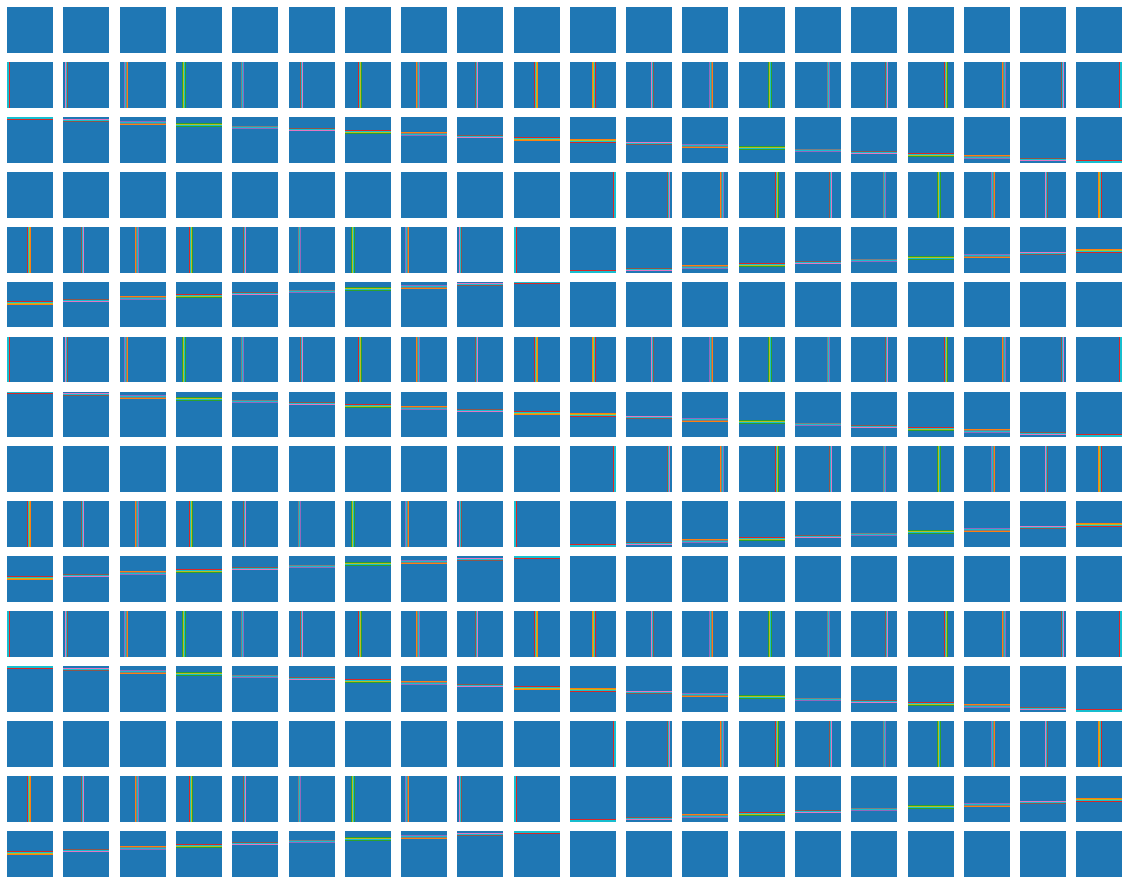

This is the average plot of all frames together


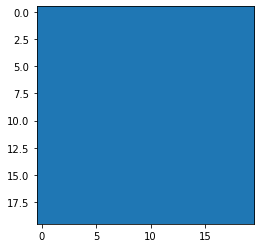

In [55]:
show_runs(standard_run)

# Create one function where you only have to enter a standard run and optionally a tsv name (this can be subject specific). The violated run will be returned, along with only the violations in an empty run and the total run for that subject.

In [56]:
# This function now only saves the violated run to the run_list dictionary, but this can easily be changed to the total run, which is the combined standard run, violated run, and only violations run.

def create_violation_run(run = standard_run, tsv_name = 'violated_run.tsv'):
    """do it all in one function, create the violations, violate the original, regular run and save it in a .tsv file"""
    
    # create a list with all list with positions, which can be randomly shuffled to make the violations     
    positions_1 = np.round(np.linspace(start_end_positions[0],start_end_positions[1],20),6)
    positions = positions_1[1:-1]

    # Create empty arrays with two columns to make the violations, the first column is the orientation (vertical = 0, horizontal = 90) and the second column are the violation values  
    hori_violations = []
    verti_violations = []


    # randomly shuffle the violations to create random violations of the standard run and return these arrays     
    random.shuffle(positions)    
    hori_violations[:] = positions

    random.shuffle(positions)
    verti_violations[:] = positions
     
     # create a list with all positions (every bar position without the first and the last one), which we can loop over to ensure that we violate every position once
    positions = positions_1[1:-1] 
    
    # get the indices of the individual vertical and horizontal bar positions, so that we can find the all the indices for each bar-position in the vertical and horizontal orientatio    
    pos_vertical = []
    pos_horizontal = []

    for i, value in enumerate(run[:,0]):
        if value == 0 or value == 180:
            pos_vertical.append(i)
        elif value == 90 or value ==270:
            pos_horizontal.append(i)
    
    # create new runs as a copy of the original run, which we can alter to our wished new configurations
    violated_run = run.copy()
    omission_run = run.copy()
    empty_run = run.copy()
    empty_run[:,1] = 0
    
    # create empty lists, so that we know at which indices a violation is going to happen. this can also help us check at a later point, if all the positions are violated.
    check_v = []
    check_h = []
    
    # This is the for-loop to introduce the violations, we loop over the positions list, as we want to introduce one violation at every position, we then check what indices there are for every position in each orientation and put that in lists
    for i, value in enumerate(positions):
        indexes = [j for j, x in enumerate(run[:,1]) if x == value]
   
        vertical = []
        horizontal = []
        for j in indexes:
            if j in pos_vertical:
                vertical.append(j)
            elif j in pos_horizontal:
                horizontal.append(j)

        # choose a random position of the 6 posibilities for each horizontal or vertical index. If a violation has already been added to the check list in the previous 3 positions, choose a new index that does not have this. Finally add the chosen position to the check list to ensure that a next violation is not too close.
        position_v = random.choice(vertical)
        while (position_v-1) in check_v or (position_v-2) in check_v or (position_v-3) in check_v:
            position_v = random.choice(vertical)
        check_v.append(position_v)
        
        # use the just chosen index and violate it with the first value of the shuffled violations list and create an omission in the omission run.
        violated_run[position_v,1] = hori_violations[i]
        violated_run[position_v,0] = 90
        omission_run[position_v,0] = -1
        empty_run[position_v,1] = hori_violations[i]
        empty_run[position_v,0] = 90
        
        # do the same for the horizontal violations
        position_h = random.choice(horizontal)
        while (position_h-1) in check_h or (position_h-2) in check_h or (position_h-3) in check_h:
            position_h = random.choice(horizontal)
        check_h.append(position_h)
        
        violated_run[position_h,1] = verti_violations[i]
        violated_run[position_h,0] = 0
        omission_run[position_h,0] = -1
        empty_run[position_h,1] = verti_violations[i]
        empty_run[position_h,0] = 0

    # get the indices of the start of each barpass, to know from what point in each run, we have to add a barpass (20 positions) to the section2 run from each seperate configuration
    pos_barpasses = []   
                
    for i, value in enumerate(run[:,0]):
        if value != run[(i-1),0]:
            pos_barpasses.append(i)
            
    # create a random order for the second section, create a blank start and create a blanks section to add.
    order = ['violated', 'omission', 'violations']
    section2_run = run[:20,:].copy()
    blanks = run[60:70,:].copy()
    
    # randomly shuffle the order of the configurations, add a blanks section at each indicated point and for all other points, add the barpass for each configuration.
    for i in pos_barpasses:
        random.shuffle(order)
        if i == 60 or i == 110 or i == 160 or i == 210 or i == 260 or i == 310:
            section2_run = np.concatenate((section2_run, blanks))
        else:
            for j in order:
                if j == 'violated':
                    section2_run = np.concatenate((section2_run, violated_run[i:(i+20),:]))
                    
                elif j == 'omission':
                    section2_run = np.concatenate((section2_run, omission_run[i:(i+20),:]))
                    
                elif j == 'violations':
                    section2_run = np.concatenate((section2_run, empty_run[i:(i+20),:]))
    
    section1_run = np.concatenate((run, run))
    
    total_run = np.concatenate((section1_run, blanks, section2_run))

        
    # create empty lists to create a dictionary, from that a dataframe and finally a tsv file to create the trial list necessary for in the session file  
    list1 = []
    list2 = []
    list3 = []
    
    # fill the empty lists with the values from the violated run, append these values into a dictionary and create a dataframe from this dictionary
    for i, value in enumerate(total_run[:,0]):
        list1.append(value)
        list2.append(total_run[i,1])
        list3.append(total_run[i,2])
        
    trial_list = {"orientation_at_TR":[], 'pos_in_ori_at_TR':[], "direction_at_TR":[]}
    
    for i in range((len(list1))):
        trial_list['orientation_at_TR'].append(list1[i])
        trial_list['pos_in_ori_at_TR'].append(list2[i])
        trial_list['direction_at_TR'].append(list3[i])
    
    df = pd.DataFrame(trial_list)

    # save the dataframe as a .tsv file with the name given (has to be a string ending with .tsv, subject number could  be used for clarification)
    name = 'run_list/' + tsv_name
    df.to_csv(name, sep='\t', index=True, na_rep='NA')

    # return the violated run, and violations, so that both can be checked if wanted      
    return empty_run, violated_run, omission_run, section1_run, section2_run, total_run 

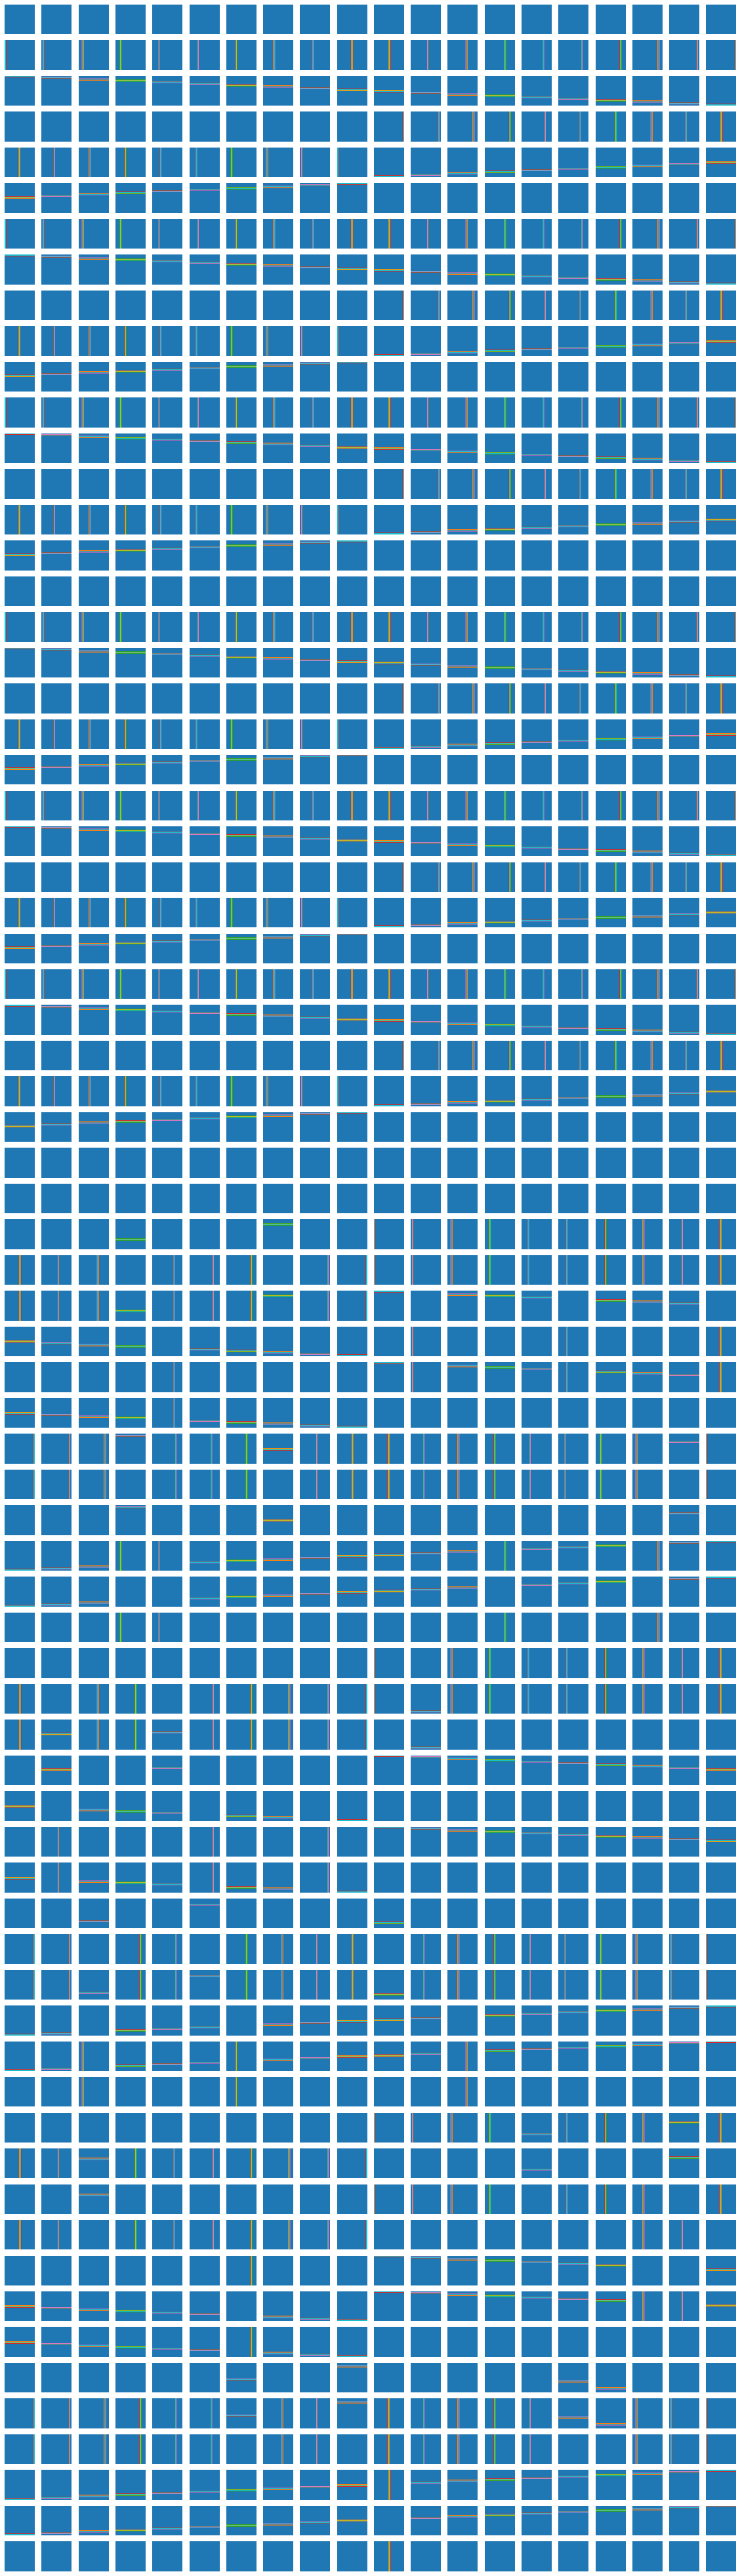

This is the average plot of all frames together


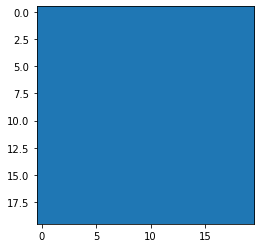

In [57]:
violations, violated_run, omissions, section1, section2, total_run = create_violation_run(tsv_name='small_bars.tsv')

# show_runs(omissions)
# show_runs(violations)
show_runs(total_run)

# This is a different way of doing it, where two functions first can make the violations and positions of the violations/omissions, then the new_run function creates a new run in which the omissions and violations are inserted into a new run. This again ensures that all positions/violation possibilities are used and that there are at least 3 positions between the omissions/violations. These functions do it in a more systematic way, where it loops over the first six values, then the second six, etc. Whereas the last function just randomly choses values, which can cause the violations/omissions to not be evenly distributed across the run

In [58]:
def viol_4_omissions(n_pos:int=18):
    """function to make a random order of 18 positions to use as violations"""
    return np.random.permutation(np.arange(n_pos))

def omissions_2_barpasses(n_bps:int=6, 
                          n_pos:int=18,
                         min_diff:int=3):
    """function to make random positions to be violated in three consecutive runs. This is done for six barpasses (horizontal or vertical in both directions). 
    For the complete randomization of the omission/violation positions in three runs, this function has to be executed twice to find the horizontal and vertical positions.
    With this function, there are 3 omissions/violations per barpass and they have a minimum distance of 3 positions. """
    n_subblocks = int(n_pos//n_bps)
    n_bars_per_subblock = int(n_pos//n_subblocks)
    subblock_positions = np.arange(n_bars_per_subblock)
    total_diff = 2
    while total_diff != 0:
        all_bps = np.array([(n_bars_per_subblock*i)+np.random.permutation(subblock_positions) for i in range(n_subblocks)])
        total_diff = np.sum(np.diff(all_bps, axis=0)<min_diff)
          
    return all_bps

In [59]:
viols = (np.vstack((viol_4_omissions(), viol_4_omissions()))).T

oms_v = omissions_2_barpasses()
oms_h = omissions_2_barpasses()
print(oms_v)

[[ 0  5  1  3  2  4]
 [ 9 10  6 11  7  8]
 [16 15 12 14 17 13]]


In [60]:
def new_run(run = standard_run, viols = viols, oms_v = oms_v, oms_h = oms_h, tsv_name = 'violated_run.tsv' ):
    """A second function to create new runs with omissions, violations and only violations, using the previous functions as the randomization. 
    Eventually, the old and new runs are combined to create two seperate sections (section1 = 6 runs regular prf-barpasses, section2 = all new configurations).
    The two sections are combined for the total run lasting approximately 50 mins total. The total run is saved to a .tsv file, for which the name is defined in a function argument
    All novel configurations, sections and the total run are returned"""
    
    positions = np.round(np.linspace(start_end_positions[0],start_end_positions[1],20),6)
    posi = positions[1:-1]
    
    # create new runs as a copy of the original run, which we can alter to our wished new configurations
    violated_run = run.copy()
    omission_run = run.copy()
    empty_run = run.copy()
    empty_run[:,1] = 0
    
    # find the values where the bar-passes start, seperate for the horizontal and vertical bar-passes.
    bp_v = []
    bp_h = []
    
    for i, value in enumerate(run[:,0]):
        if value == 0 or value == 180:
            if value != run[(i-1),0]:
                bp_v.append(i)
        elif value == 90 or value == 270:
            if value != run[(i-1),0]:
                bp_h.append(i)
     
    # Use the indices of the bar-passes +1 (as we are not violating/omitting the first and the last position) as the start of the bar-pass. Then omitt/violate the pre-determined position (with the pre-determined violation)
    for i, index in enumerate(bp_v):
        for j, value in enumerate(posi):
            h_viol = posi[(viols[j,0])]
            viol_index = int(index + j + 1)
            for k in range(3):
                if j == oms_v[k,i]:
                
                    # use the just chosen index and violate it with the first value of the shuffled violations list for the violation and empty run and create an omission in the omission run.
                    violated_run[viol_index,1] = h_viol
                    violated_run[viol_index,0] = 90
                    omission_run[viol_index,0] = -1
                    empty_run[viol_index,1] = h_viol
                    empty_run[viol_index,0] = 90
    
    # Do the same for the horizontal bar-passes
    for i, index in enumerate(bp_h):
        for j, value in enumerate(posi):    
            v_viol = posi[viols[j,1]]
            viol_index = int(index + j + 1)
            for k in range(3):
                if j == oms_h[k,i]:
                    
                    violated_run[viol_index,1] = v_viol
                    violated_run[viol_index,0] = 0
                    omission_run[viol_index,0] = -1
                    empty_run[viol_index,1] = v_viol
                    empty_run[viol_index,0] = 0
    
    # get the indices of the start of each barpass, to know from what point in each run, we have to add a barpass (20 positions) to the section2 run from each seperate configuration
    pos_barpasses = []   
                
    for i, value in enumerate(run[:,0]):
        if value != run[(i-1),0]:
            pos_barpasses.append(i)
            
    # create a random order for the second section, create a blank start and create a blanks section to add.
    order = ['violated', 'omission', 'violations']
    section2_run = run[:20,:].copy()
    blanks = run[60:70,:].copy()
    
    # randomly shuffle the order of the configurations, add a blanks section at each indicated point and for all other points, add the barpass for each configuration.
    for i in pos_barpasses:
        random.shuffle(order)
        if i == 60 or i == 110 or i == 160 or i == 210 or i == 260 or i == 310:
            section2_run = np.concatenate((section2_run, blanks))
        else:
            for j in order:
                if j == 'violated':
                    section2_run = np.concatenate((section2_run, violated_run[i:(i+20),:]))
                    
                elif j == 'omission':
                    section2_run = np.concatenate((section2_run, omission_run[i:(i+20),:]))
                    
                elif j == 'violations':
                    section2_run = np.concatenate((section2_run, empty_run[i:(i+20),:]))
    
    # concatenate two regular runs for the first section and concatenate the two sections for the total run (with an intermediate extra long blank section)
    section1_run = np.concatenate((run, run))
    
    total_run = np.concatenate((section1_run, blanks, section2_run))
        
    # create empty lists to create a dictionary, from that a dataframe and finally a tsv file to create the trial list necessary for in the session file  
    list1 = []
    list2 = []
    list3 = []
    
    # fill the empty lists with the values from the violated run, append these values into a dictionary and create a dataframe from this dictionary
    for i, value in enumerate(total_run[:,0]):
        list1.append(value)
        list2.append(total_run[i,1])
        list3.append(total_run[i,2])
        
    trial_list = {"orientation_at_TR":[], 'pos_in_ori_at_TR':[], "direction_at_TR":[]}
    
    for i in range((len(list1))):
        trial_list['orientation_at_TR'].append(list1[i])
        trial_list['pos_in_ori_at_TR'].append(list2[i])
        trial_list['direction_at_TR'].append(list3[i])
    
    df = pd.DataFrame(trial_list)

    # save the dataframe as a .tsv file with the name given (has to be a string ending with .tsv, subject number could  be used for clarification)
    name = 'run_list/' + tsv_name
    df.to_csv(name, sep='\t', index=True, na_rep='NA')

    # return the violated run, and violations, so that both can be checked if wanted      
    return empty_run, violated_run, omission_run, section1_run, section2_run, total_run 

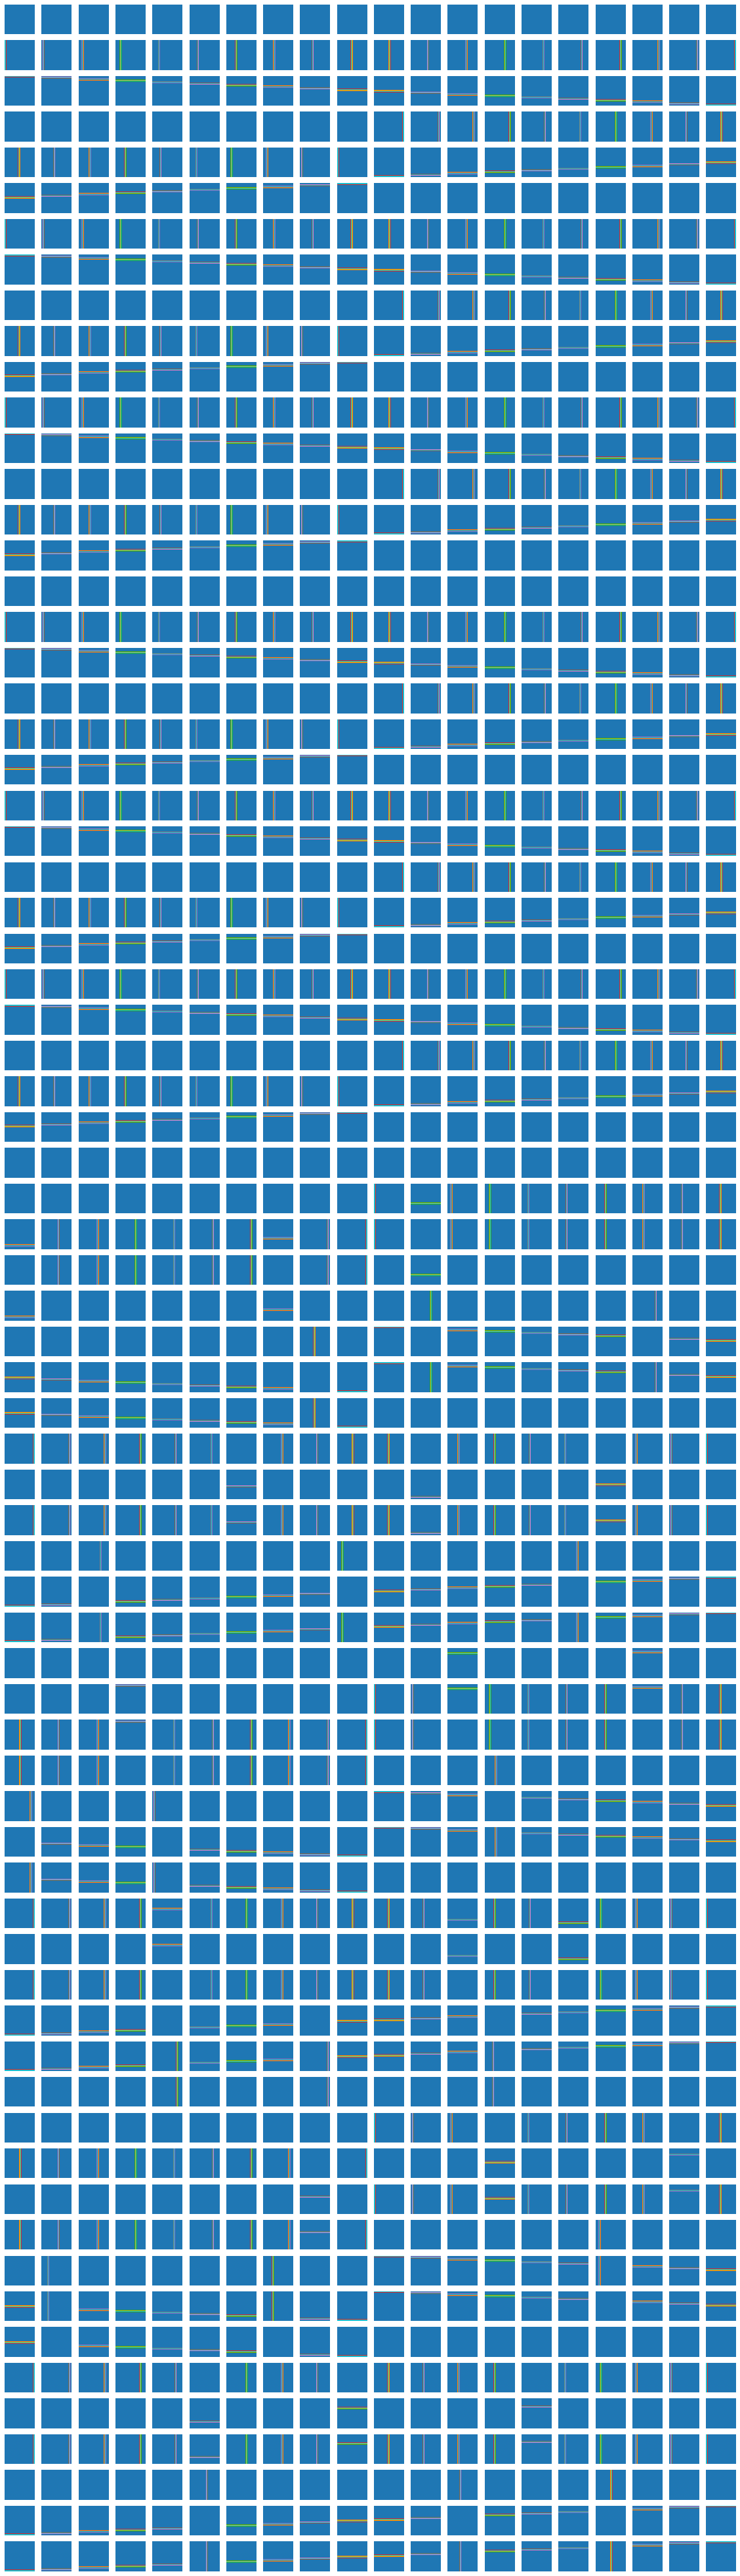

This is the average plot of all frames together


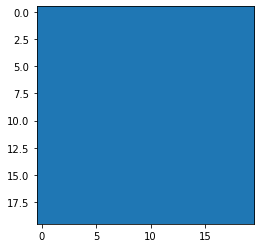

In [61]:
np.set_printoptions(threshold=np.inf)

violations, violated_run, omissions, section1, section2, total = new_run(tsv_name = 'novel_run.tsv')
show_runs(total)